# PushShift Reddit dump dataset
<u> Includes: </u>
- Read in and merge preprocessed data (filtering done in ``preprocess.py``)
- Filter:
    - By user / subreddit features:
        - Only keep users with **more than 10** posts
        - Only keeping subreddits with more than **10** posts
        - Only keep users posting in more than **3** different subreddits
        - Only keep subreddits with more than **10** users
    - By submission features:
        - Keep English posts only
    - <u> Checkpoint file</u>: `processed/pushshift/filtered.txt`
- Build dataset
    - Keep 500 top subreddits
    - Keep users with **10 posts** in those subreddits
    - <u> Checkpoint file</u>: `processed/pushshift/dataset_500sr.txt`
- Visualize dataset characteristics
    - Users
        - Number of posts
        - Number of unique subreddits
    - Subreddits
        - Number of posts
        - Number of unique users
- Encode using DistilBertTokenizer and store encodings in .csv
    - Truncate to max 512 tokens
    - Filter duplicates
    - <u> Checkpoint file</u>: `processed/pushshift/dataset_500sr_encoded.txt`
- Further preprocessing
    - One-hot encode the subreddits
    - Pick partial one-hot vector as input
    - Train/dev/test split
    - Stack by user
- Save as TF record

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
import re
from IPython.display import clear_output
import itertools
from tools.preprocess import (merge_csv, add_aggregate_metrics, 
                              plot_aggregates, update_aggregates, 
                              log_size)
from tools.mask import mask_dataset
from tools.datasets import (save_tfrecord_nn1, load_tfrecord_nn1)
import random
import fasttext
from sklearn.model_selection import GroupShuffleSplit

Set parameters

In [2]:
min_posts_per_user = 10
min_posts_per_subreddit = 10
min_unique_users_per_subreddit = 10
min_unique_subreddits_per_user = 3

In [3]:
sizedict = {'names':[], 'users':[], 'posts':[], 'subreddits':[]}
sizelog = 'processed/pushshift/size_log.json'
sizedict = json.load(open(sizelog))

## Filtering
### By user and subreddit features

In [ ]:
df = merge_csv('raw/pushshift')

In [5]:
sr_df = pd.read_csv('misc/top_1000_subreddits.txt', sep='\t', index_col=0)

In [6]:
df = df[~df['subreddit'].isnull()]

Log size metrics before any filtering

In [7]:
sizedict = log_size(df, sizedict, 'no_filter', sizelog)
print(f'Before filtering, there are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

Before filtering, there are 2803656 users, 7731642 posts, 907 subreddits


#### Filter users for minimum number of posts and minumum number of subreddits


In [8]:
df = add_aggregate_metrics(df, 'author', 'count', ['author', 'user_posts_count'])
df = add_aggregate_metrics(df, 'author', lambda x: x.nunique(), ['author', 'user_nr_unique_subreddits'], agg_on='subreddit')
df = df[(df['user_posts_count'] >= min_posts_per_user) & (df['user_nr_unique_subreddits'] >= min_unique_subreddits_per_user)]

In [9]:
sizedict = log_size(df, sizedict, 'user_filter', sizelog)
print(f'After filtering, there are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

After filtering, there are 87597 users, 1920537 posts, 757 subreddits


#### Filter subreddits for minimum number of posts and minimum number of users

In [10]:
df = add_aggregate_metrics(df, 'subreddit', 'count', ['subreddit', 'subreddit_posts_count'])
df = add_aggregate_metrics(df, 'subreddit', lambda x: x.nunique(), ['subreddit', 'subreddit_nr_unique_users'], agg_on='author')
df = df[(df['subreddit_posts_count'] >= min_posts_per_subreddit) & (df['subreddit_nr_unique_users'] >= min_unique_users_per_subreddit)]

In [11]:
sizedict = log_size(df, sizedict, 'subreddit_filter', sizelog)
print(f'After filtering, there are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

After filtering, there are 87596 users, 1918381 posts, 549 subreddits


#### Filter by language (English only)

In [12]:
langdetect = fasttext.load_model('fasttext/lid.176.bin')
def language_detection(s):
    try:
        s = re.sub('\n', ' ', s)
        return langdetect.predict(' '.join(s.split(' ')[:5]))[0][0].split('__')[2]
    except:
        return 'unk'

In [13]:
df['lang'] = df['selftext'].apply(language_detection)
df = df[df['lang'] == 'en']

In [111]:
sizedict = log_size(df, sizedict, 'lang_filter', sizelog)
print(f'After filtering, there are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

After filtering, there are 87595 users, 1866822 posts, 549 subreddits


In [103]:
df = update_aggregates(df)
df.to_csv('processed/pushshift/filtered.txt', sep='\t', index=False)
df = pd.read_csv('processed/pushshift/filtered.txt', sep='\t')

### Visualize dataset stats 

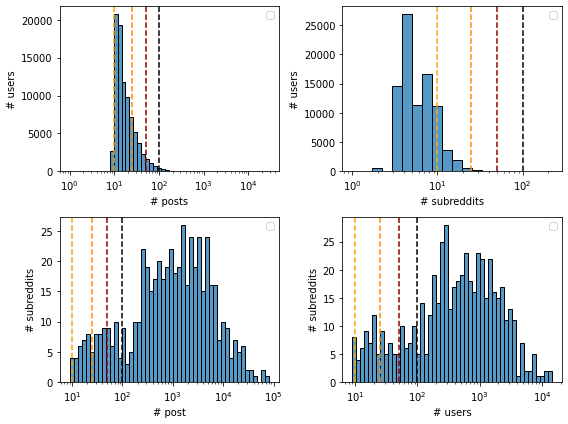

In [110]:
plot_aggregates(df, bins=[50, 20, 50, 50], vlines=[10, 25, 50, 100], figsize=(8,6), nrows=2, ncols=2)

## Subset subreddits
Here, we create a dataset including only the top 500 subreddits.

In [112]:
srdict = {}
for sr in df.subreddit.unique():
    srdict[sr] = df[df['subreddit'] == sr]['subreddit_posts_count'].iloc[0]
srdict = [(k,v) for k, v in sorted(srdict.items(), reverse=True, key=lambda item: item[1])]
srdict = srdict[:500]
srdict = [s[0] for s in srdict]

In [113]:
df = df[df['subreddit'].isin(srdict)]
df = update_aggregates(df)

In [114]:
sizedict = log_size(df, sizedict, '500sr_subset', sizelog)
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 87594 users, 1865767 posts, 500 subreddits


## Further preprocessing

Drop duplicates

In [115]:
df = df.drop_duplicates('selftext')
df = update_aggregates(df)

In [116]:
sizedict = log_size(df, sizedict, '5000sr_drop_duplicates', sizelog)
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 87594 users, 1830950 posts, 500 subreddits


Recount user posts and filter

In [117]:
df = df[(df['user_posts_count'] >= min_posts_per_user) & (df['user_nr_unique_subreddits'] >= min_unique_subreddits_per_user)]
df = update_aggregates(df)
print(f'Number of posts: {df.shape[0]}')

Number of posts: 1792618


Check if all subreddits satisfy the criteria

In [118]:
all(df['subreddit_posts_count'] >= min_posts_per_subreddit) and all(df['subreddit_nr_unique_users'] >= min_unique_users_per_subreddit)

True

Recompute size and store

In [119]:
sizedict = log_size(df, sizedict, '500sr_user_filter', sizelog)
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 83660 users, 1792618 posts, 500 subreddits


In [120]:
df.to_csv('processed/pushshift/dataset_500sr.txt', sep='\t', index=False)
#df = pd.read_csv('processed/pushshift/dataset_500sr.txt', sep='\t')

## Encode dataset
Set up tokenizer and encode all posts. <br>
Posts with > 512 tokens are truncated, shorter posts are padded to 512.

In [121]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [122]:
df['selftext'] = df['selftext'].astype('str')

In [127]:
idxs = list(np.arange(0, df.shape[0], 100000)) + [df.shape[0]]
start = timeit.default_timer() 
timestamp = start

for i in range(len(idxs) - 1):
    print(f'Timestamp previous step {timestamp - start}')
    print(f'Encoding posts {idxs[i]} to {idxs[i+1]} out of {df.shape[0]}')
    clear_output(wait=True)
    tokenized = df['selftext'][idxs[i]:idxs[i+1]].apply(lambda x: tokenizer.encode_plus(' '.join(x.split()[:400]), 
                                                                                        truncation=True, 
                                                                                        padding='max_length'))
    if i == 0:
        tokdf = pd.DataFrame(tokenized)
    else:
        tokdf = pd.concat([tokdf, pd.DataFrame(tokenized)], ignore_index=True)
    timestamp = timeit.default_timer()

Timestamp previous step 2694.788070516999
Encoding posts 1700000 to 1792618 out of 1792618


Splice output dictionary in two columns and merge.

In [128]:
df['input_ids'] = tokdf['selftext'].apply(lambda x: x['input_ids'])
df['attention_mask'] = tokdf['selftext'].apply(lambda x: x['attention_mask'])

In [129]:
sizedict = log_size(df, sizedict, 'tokenize', sizelog)
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 83660 users, 1792618 posts, 500 subreddits


In [130]:
df.to_csv('processed/pushshift/dataset_500sr_encoded.txt', sep='\t', index=False)

## Plot final dataset

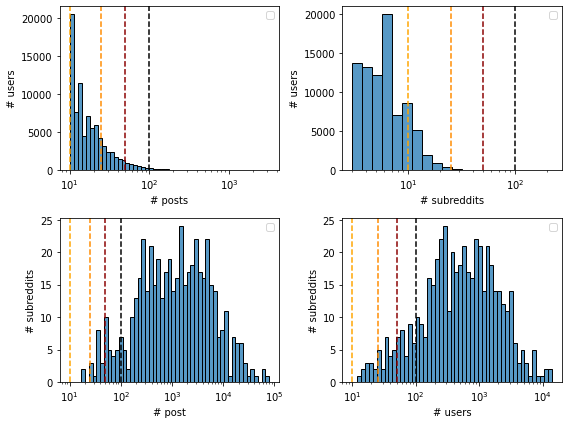

In [131]:
plot_aggregates(df, bins=[50, 20, 50, 50], vlines=[10, 25, 50, 100], figsize=(8,6), nrows=2, ncols=2)

In [132]:
print(f'There are {df.author.nunique()} users, {df.shape[0]} posts, {df.subreddit.nunique()} subreddits')

There are 83660 users, 1792618 posts, 500 subreddits


In [133]:
print(f'Min - avg - max posts per user: {df.user_posts_count.min()}, {df.user_posts_count.mean()}, {df.user_posts_count.max()}')
print(f'Min - avg - max subreddits per user: {df.user_nr_unique_subreddits.min()}, {df.user_nr_unique_subreddits.mean()}, {df.user_nr_unique_subreddits.max()}')
print(f'Min - avg - max posts per subreddit: {df.subreddit_posts_count.min()}, {df.subreddit_posts_count.mean()}, {df.subreddit_posts_count.max()}')
print(f'Min - avg - max users per subreddit: {df.subreddit_nr_unique_users.min()}, {df.subreddit_nr_unique_users.mean()}, {df.subreddit_nr_unique_users.max()}')

Min - avg - max posts per user: 10, 52.6554592222102, 3180
Min - avg - max subreddits per user: 3, 8.230257645521801, 219
Min - avg - max posts per subreddit: 17, 18894.090659582802, 78690
Min - avg - max users per subreddit: 12, 4082.1149988452644, 13808


Plot dataset size curve

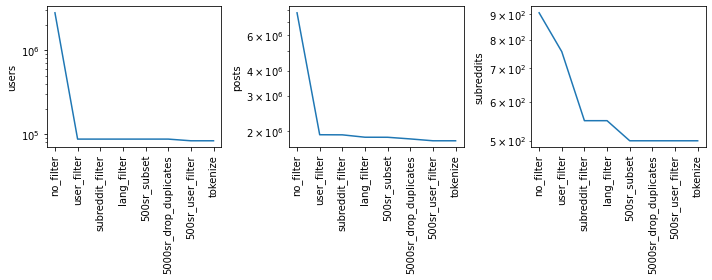

In [134]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4), sharex=True)
for idx, metric in enumerate(['users', 'posts', 'subreddits']):
    sns.lineplot(x=sizedict['names'], y=sizedict[metric], ax=ax[idx])
    ax[idx].set_ylabel(metric)
    ax[idx].set_yscale('log')
    ax[idx].set_xticklabels(sizedict['names'], rotation=90)
plt.tight_layout()
plt.show()

## One-hot encode subreddits

In [3]:
df = pd.read_csv('processed/pushshift/dataset_500sr_encoded.txt', 
                 converters={'input_ids': lambda x: json.loads(x),
                             'attention_mask': lambda x: json.loads(x)}, sep='\t')

In [4]:
df = df.sort_values('created_utc').reset_index(drop=True)

In [5]:
df['one_hot_subreddit'] = pd.get_dummies(df['subreddit']).values.tolist()

In [6]:
df['label_subreddit'] = df['one_hot_subreddit'].apply(lambda x: np.where(np.array(x) == 1)[0][0])

Make sure that there is no huge imbalance in category frequency by order (as, for one of the networks, we'll truncate the encoding to 250th dimension so to include that in the input).

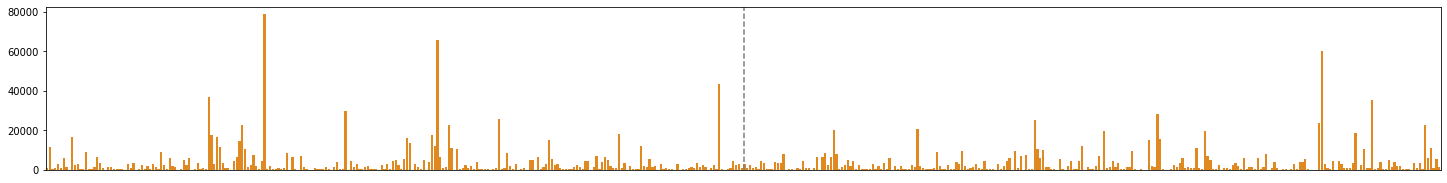

In [7]:
fig, ax = plt.subplots(figsize=(25,3))
ax.axvline(250, linestyle='--', color='grey')
sns.barplot(x=df['label_subreddit'].value_counts().index, y=df['label_subreddit'].value_counts().values, color='darkorange')
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.show()

Also store truncated version

In [8]:
df['one_hot_truncated'] = df['one_hot_subreddit'].apply(lambda x: x[:250])

In [9]:
label_map = df[['subreddit', 'one_hot_subreddit']].groupby('subreddit').aggregate('first')
label_map['one_hot_subreddit'] = [np.where(np.array(l) == 1)[0][0] for l in label_map['one_hot_subreddit']]
label_dict = dict(zip(list(label_map['one_hot_subreddit']), list(label_map.index)))
json.dump(label_dict, open('labels/reddit_2008.json', 'w'))

## Train - dev - test indices

In [10]:
x_cols = ['input_ids', 'attention_mask']
group_col = 'author'
y_col = 'label_subreddit'

Define split object for both full dataset, and a smaller toy dataset

In [11]:
gsplit_main = GroupShuffleSplit(n_splits=1, train_size=.70, test_size=.15, random_state=0)
gsplit_small = GroupShuffleSplit(n_splits=1, train_size=.25, test_size=.05, random_state=0)

Split full dataset

In [12]:
split_main = list(gsplit_main.split(X=df[x_cols].values, 
                                    y=df[y_col].values, 
                                    groups=df[group_col].values))
train_idx, test_idx = list(split_main[0][0]), list(split_main[0][1])
dev_idx = list(set(range(df.shape[0])) - set(train_idx + test_idx))

Split toy dataset

In [13]:
split_small = list(gsplit_small.split(X=df[x_cols].values, 
                                      y=df[y_col].values, 
                                      groups=df[group_col].values))
train_idx_small, test_idx_small = list(split_small[0][0]), list(split_small[0][1])

## Visualize resulting dataset

In [14]:
ds_cols = ['author', 'input_ids', 'attention_mask', 'one_hot_subreddit']

In [15]:
train = df.iloc[train_idx]
dev = df.iloc[dev_idx]
test = df.iloc[test_idx]

In [16]:
print(f'There are {train.shape[0]} examples, {train.author.nunique()} unique users in the training set')
print(f'There are {dev.shape[0]} examples, {dev.author.nunique()} unique users in the validation set')
print(f'There are {test.shape[0]} examples, {test.author.nunique()} unique users in the test set')

There are 1255364 examples, 58561 unique users in the training set
There are 270712 examples, 12550 unique users in the validation set
There are 266542 examples, 12549 unique users in the test set


Visualize number of posts per user

In [17]:
train = update_aggregates(train)
dev = update_aggregates(dev)
test = update_aggregates(test)

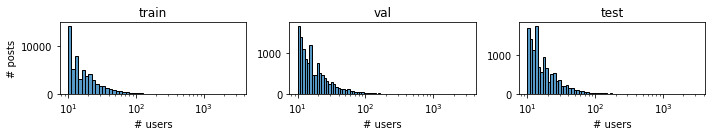

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,2), sharex=True)
for a in ax:
    a.set_xscale('log')
    a.set_xlabel('# users')
    a.set_ylabel('# posts')
sns.histplot(train[['author','user_posts_count']].groupby('author').aggregate('first'), ax=ax[0], bins=50, legend=None)
ax[0].set_title('train')
sns.histplot(dev[['author','user_posts_count']].groupby('author').aggregate('first'), ax=ax[1], bins=50, legend=None)
ax[1].set_title('val')
ax[1].set_ylabel('')
sns.histplot(test[['author','user_posts_count']].groupby('author').aggregate('first'), ax=ax[2], bins=50, legend=None)
ax[2].set_title('test')
ax[2].set_ylabel('')
plt.tight_layout()
plt.show()

Visualize number and distribution of subreddits

In [19]:
print(f'There are {train.shape[0]} examples, {train.subreddit.nunique()} unique subreddits in the training set')
print(f'There are {dev.shape[0]} examples, {dev.subreddit.nunique()} unique subreddits in the validation set')
print(f'There are {test.shape[0]} examples, {test.subreddit.nunique()} unique subreddits in the test set')

There are 1255364 examples, 500 unique subreddits in the training set
There are 270712 examples, 500 unique subreddits in the validation set
There are 266542 examples, 500 unique subreddits in the test set


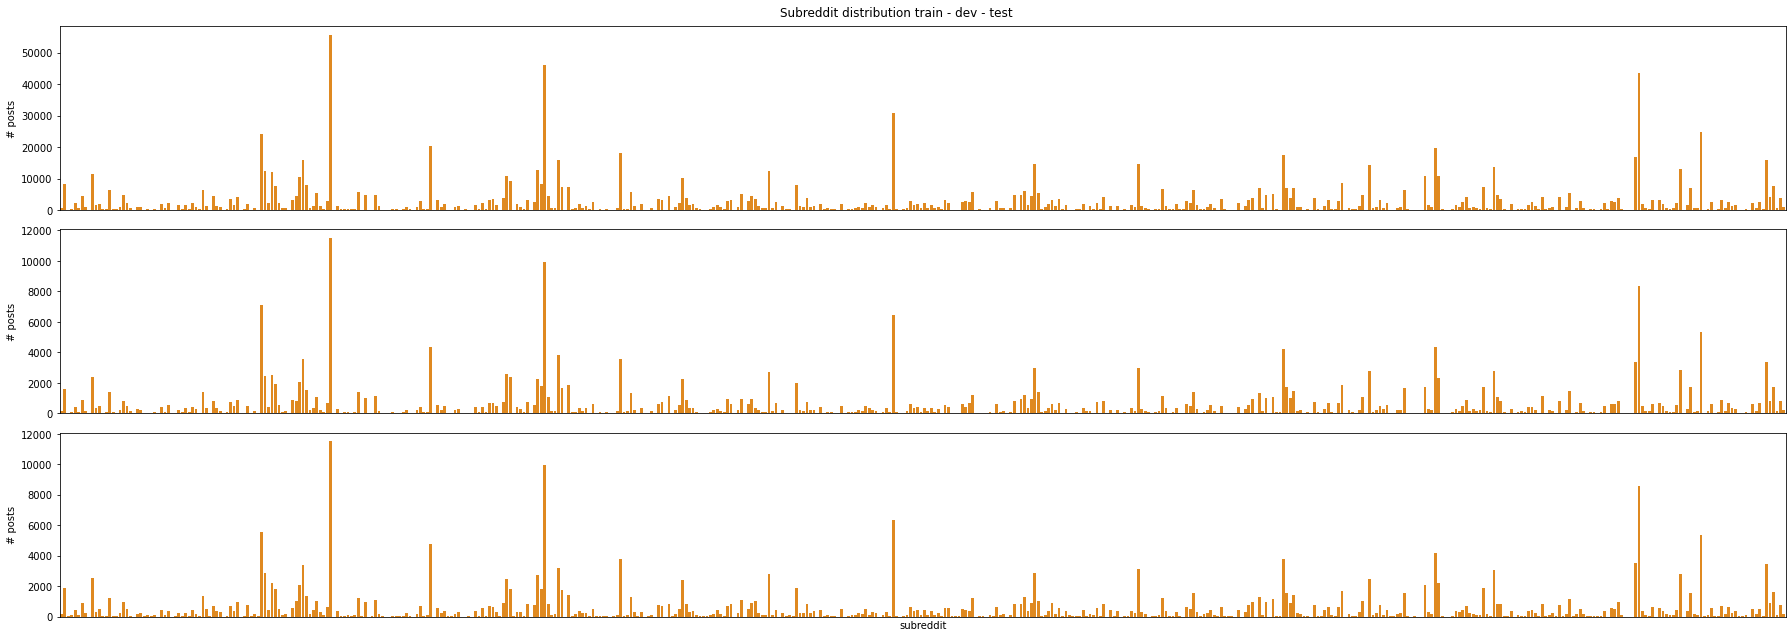

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25,9), sharex=True)
for a in ax:
    if a in ax[:2]:
        a.set_xlabel('')
    else:
        a.set_xlabel('subreddit')
    a.set_ylabel('# posts')
sns.barplot(x=train['label_subreddit'].value_counts().index, 
            y=train['label_subreddit'].value_counts().values, ax=ax[0], color='darkorange')
sns.barplot(x=dev['label_subreddit'].value_counts().index, 
            y=dev['label_subreddit'].value_counts().values, ax=ax[1], color='darkorange')
sns.barplot(x=test['label_subreddit'].value_counts().index, 
            y=test['label_subreddit'].value_counts().values, ax=ax[2], color='darkorange')
for a in ax:
    a.set_xticks([])
fig.suptitle('Subreddit distribution train - dev - test')
fig.tight_layout()
fig.subplots_adjust(top=.95)
plt.show()

## Visualize toy dataset

In [21]:
train_small = df.iloc[train_idx_small]
test_small = df.iloc[test_idx_small]

In [22]:
print(f'There are {train_small.shape[0]} examples, {train_small.author.nunique()} unique users in the training set')
print(f'There are {test_small.shape[0]} examples, {test_small.author.nunique()} unique users in the test set')

There are 452795 examples, 20915 unique users in the training set
There are 85451 examples, 4183 unique users in the test set


In [23]:
print(f'There are {train_small.shape[0]} examples, {train_small.subreddit.nunique()} unique subreddits in the training set')
print(f'There are {test_small.shape[0]} examples, {test_small.subreddit.nunique()} unique subreddits in the test set')

There are 452795 examples, 500 unique subreddits in the training set
There are 85451 examples, 489 unique subreddits in the test set


## Create "pseudo-batches"
Posts are grouped by user and stacked vertically so that one row contains full data for one example

In [24]:
def stack_fn(x):
    return [np.vstack(np.array(x))]

In [ ]:
train_stacked = train[ds_cols].groupby('author').aggregate(stack_fn).reset_index()
dev_stacked = dev[ds_cols].groupby('author').aggregate(stack_fn).reset_index()
test_stacked = test[ds_cols].groupby('author').aggregate(stack_fn).reset_index()

In [33]:
train_small_stacked = train_small[ds_cols].groupby('author').aggregate(stack_fn).reset_index()
test_small_stacked = test_small[ds_cols].groupby('author').aggregate(stack_fn).reset_index()

Also create a version of the example where grouping is random

In [ ]:
df_shuffled = df.copy()
df_shuffled['author'] = np.random.permutation(df_shuffled['author'].values)

In [ ]:
train_shuffled_stacked = df_shuffled.iloc[train_idx][ds_cols].groupby('author').aggregate(stack_fn).reset_index()
dev_shuffled_stacked = df_shuffled.iloc[dev_idx][ds_cols].groupby('author').aggregate(stack_fn).reset_index()
test_shuffled_stacked = df_shuffled.iloc[test_idx][ds_cols].groupby('author').aggregate(stack_fn).reset_index()

## Convert to dataset

In [34]:
input_names = ['input_ids', 'attention_mask']
output_names = ['one_hot_subreddit']
types = (tf.int32, tf.int32), (tf.int32)

In [35]:
def nn1_gen(ds):
    for i in range(ds.shape[0]):
        yield tuple( [ds[inpn].iloc[i][0] for inpn in input_names] ), \
              ds[output_names[0]].iloc[i][0]

In [36]:
ds_dfs = [train_small_stacked, test_small_stacked]#, 
          #train_stacked, dev_stacked, test_stacked,
          #train_shuffled_stacked, dev_shuffled_stacked, test_shuffled_stacked]
ds_dfs = [d.reset_index() for d in ds_dfs]
ds_names = ['nn1_small'] * 2 #+ ['nn1'] * 3 + ['nn1_shuffled'] * 3
ds_types = ['train', 'test'] #+ ['train', 'dev', 'test'] * 2

In [43]:
for  d in ds_dfs:
    ds = tf.data.Dataset.from_generator(generator=lambda: nn1_gen(d), 
                                        output_types=types)
    save_tfrecord_nn1(ds, filename='test_ds', 
                      shard=True, n_shards=1000, 
                      path='datasets/test/',
                      compression='GZIP')

Saving b'datasets/test/999-of-1000.tfrecord' ...


<span style="color:red"> 
Further to dos: <br> 
- Figure out model fitting issues